In [1]:
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from modules import *
import json

In [87]:
gpt2 = {'l': 1024, 'e': 1600, 'h': 32, 'depth': 48}
gpt3 = {'l': 2048, 'e': 12288, 'h': 256, 'depth': 96}
gpt3_lowdepth = {'l': 2048, 'e': 12288, 'h': 256, 'depth': 96 // 8}
vit_era5 = {'l': 64800, 'e': 5120, 'h': 256, 'depth': 24}
### model
model = vit_era5#gpt3
b = 1
l = model['l']
e = model['e']
f = 4 * e
h = model['h']
depth = model['depth']
print("model: batch size = {}, seq length = {}, embed = {}, attention heads = {}, depth = {}".format(b, l, e, h, depth))

model: batch size = 1, seq length = 64800, embed = 5120, attention heads = 256, depth = 24


In [88]:
with open('config.json', 'r') as file:
    system = json.load(file)

In [89]:
def print_df(df_mlp, df_sa):
    cols = df_mlp.columns.tolist()
    layer_track_cols = ['activation_buffer', 'weights_mem', 
                        'weights_grad_mem', 'flops_fwd', 'flops_bwd', 
                        't_fwd', 't_fwd_comm', 't_bwd', 't_bwd_comm']
    display(df_mlp[cols])
    display(df_mlp[layer_track_cols].sum() * depth)
    display(df_sa[cols])
    display(df_sa[layer_track_cols].sum() * depth)
    t_itr = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum() + df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum()) * depth
    print('time for 1 itr = {}'.format(t_itr))

    f1 = 3 # 1 fp16 wt, 1 fp32 copy
    f2 = 5 # 1 fp16 grad, 2 fp32 means and variances
    mem = (df_mlp['weights_mem'].sum() * f1 + df_mlp['weights_grad_mem'].sum() * f2 + df_mlp['activation_buffer'].sum() +
           df_sa['weights_mem'].sum() * f1 + df_sa['weights_grad_mem'].sum() * f2 + df_sa['activation_buffer'].sum()) * depth
    print('mem consumed = {}'.format(mem))

In [90]:
m1 = 1
system['nvlink_size'] = 1
t1 = 'nvlink' if m1 <= system['nvlink_size'] else 'ib'
df_mlp = mlp_1d(b, l, e, f, depth, parallelism={'m': m1}, topology={'t': t1})
df_sa = sa_1d(b, l, e, h, depth, parallelism={'m': m1}, topology={'t': t1}, flash_attention=True)
print_df(df_mlp, df_sa)

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,fc1,0.209715,0.209715,13.588218,0.663552,0,reducescatter,27.178653,0.0,reducescatter,43.551980,0,19.198811,87.111068,0,19.200378,130.663049
1,fc1-bias,0.000041,0.000041,0.001327,0.000000,0,none,0.001327,0.0,allreduce,1.706913,0,0.009968,1.706913,0,0.009968,3.413825
2,act1,0.000000,0.000000,0.001327,2.654208,0,none,0.001327,0.0,none,3.413772,0,0.004984,5.120659,0,0.003323,8.534431
3,dpr1,0.000000,0.000000,0.001327,1.327104,0,none,0.001327,0.0,none,4.267215,0,0.003987,4.267215,0,0.003987,8.534431
4,fc2,0.209715,0.209715,13.589213,2.654208,0,reducescatter,27.177658,0.0,reducescatter,43.555170,0,19.200217,87.107878,0,19.199674,130.663049
5,fc2-bias,0.000010,0.000010,0.000332,0.000000,0,none,0.000332,0.0,allreduce,0.426728,0,0.009968,0.426728,0,0.009968,0.853456
6,dpr2,0.000000,0.000000,0.000332,0.331776,0,none,0.000332,0.0,none,1.066804,0,0.003987,1.066804,0,0.003987,2.133608
7,ln1,0.000020,0.000020,0.002986,0.663552,0,allgather,0.003981,0.0,reducescatter,0.853623,0,0.044846,2.133621,0,0.023921,2.987244


activation_buffer     199.065600
weights_mem            10.068050
weights_grad_mem       10.068050
flops_fwd             652.441485
flops_bwd            1304.758492
t_fwd                2372.212944
t_fwd_comm              0.000000
t_bwd                4534.581255
t_bwd_comm              0.000000
dtype: float64

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,qkv,0.157286,0.157286,10.191163,0.663552,0,reducescatter,20.383907,0.0,reducescatter,32.663985,0,18.066014,65.333035,0,18.067415,97.997021
1,fusedla,0.000000,0.000000,89.220854,2.720563,0,none,222.514499,0.0,none,1143.857097,0,661.869211,2852.749989,0,825.342339,3996.607086
2,vproj,0.052429,0.052429,3.397054,0.663552,0,reducescatter,6.794414,0.0,reducescatter,10.887995,0,12.272874,21.776970,0,12.273426,32.664965
3,vproj-bias,0.000010,0.000010,0.000332,0.000000,0,none,0.000332,0.0,allreduce,0.426728,0,0.009968,0.426728,0,0.009968,0.853456
4,dpr_v,0.000000,0.000000,0.000332,0.331776,0,none,0.000332,0.0,none,1.066804,0,0.003987,1.066804,0,0.003987,2.133608
5,ln2,0.000020,0.000020,0.002986,0.663552,0,allgather,0.003981,0.0,reducescatter,0.853623,0,0.044846,2.133621,0,0.023921,2.987244


activation_buffer      121.031885
weights_mem              5.033902
weights_grad_mem         5.033902
flops_fwd             2467.505303
flops_bwd             5992.739167
t_fwd                28554.149570
t_fwd_comm               0.000000
t_bwd                70643.691531
t_bwd_comm               0.000000
dtype: float64

time for 1 itr = 106104.63530092148
mem consumed = 440.9131008


In [91]:
m1 = 1
m2 = 1
t2 = 'nvlink'
t1 = 'ib'
df_mlp = mlp_2d(b, l, e, f, depth, parallelism={'m1': m1, 'm2': m2}, topology={'t1': t1, 't2': t2})
df_sa = sa_2d_seqp(b, l, e, h, depth, parallelism={'m1': m1, 'm2': m2}, topology={'t1': t1, 't2': t2})
print_df(df_mlp, df_sa)

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,fc1,0.209715,0.209715,13.589545,0.663552,"[0.0, 0.0]","[broadcast, broadcast]",27.178653,"[0.0, 0.0, 0.0, 0.0]","[broadcast, reduce, broadcast, reduce]",43.556234,0.0,19.200686,87.111068,0.0,19.200378,130.667302
1,fc1-bias,0.000041,0.000041,0.001327,0.000000,0,none,0.001327,0.0,allreduce,1.706913,0.0,0.009968,1.706913,0.0,0.009968,3.413825
2,act1,0.000000,0.000000,0.001327,2.654208,0,none,0.001327,0,none,3.413772,0.0,0.004984,5.120659,0.0,0.003323,8.534431
3,dpr1,0.000000,0.000000,0.001327,1.327104,0,none,0.001327,0,none,4.267215,0.0,0.003987,4.267215,0.0,0.003987,8.534431
4,fc2,0.209715,0.209715,13.589545,2.654208,"[0.0, 0.0]","[broadcast, broadcast]",27.177658,"[0.0, 0.0, 0.0, 0.0]","[broadcast, reduce, broadcast, reduce]",43.556234,0.0,19.200686,87.107878,0.0,19.199674,130.664112
5,fc2-bias,0.000010,0.000010,0.000332,0.000000,0,none,0.000332,0.0,allreduce,0.426728,0.0,0.009968,0.426728,0.0,0.009968,0.853456
6,dpr2,0.000000,0.000000,0.000332,0.331776,0,none,0.000332,0,none,1.066804,0.0,0.003987,1.066804,0.0,0.003987,2.133608
7,ln1,0.000259,0.000259,0.037791,8.398080,0.0,allreduce,0.050388,0.0,allreduce,10.801722,0.0,0.044854,27.003639,0.0,0.023923,37.805362


activation_buffer     384.694272
weights_mem            10.073779
weights_grad_mem       10.073779
flops_fwd             653.316627
flops_bwd            1305.872264
t_fwd                2611.094938
t_fwd_comm              0.000000
t_bwd                5131.461699
t_bwd_comm              0.000000
dtype: float64

,name,weights_mem,weights_grad_mem,flops_fwd,activation_buffer,comm_fwd,comm_fwd_type,flops_bwd,comm_bwd,comm_bwd_type,t_fwd,t_fwd_comm,intensity_fwd,t_bwd,t_bwd_comm,intensity_bwd,t
0,qkv,0.157286,0.157286,10.192159,0.663552,"[0.0, 0.0]","[broadcast, broadcast]",20.383907,"[0.0, 0.0, 0.0, 0.0]","[broadcast, reduce, broadcast, reduce]",32.667175,0.0,18.067778,65.333035,0.0,18.067415,98.000211
1,logits,0.000000,0.000000,41.923215,1.327104,0.0,allgather,85.995676,"[0.0, 0.0]","[allgather, reducescatter]",1383.431244,0.0,0.097128,2766.862487,0.0,0.099617,4150.293731
2,softmax,0.000000,0.000000,3.224846,2149.908480,0,none,4.299800,0,none,2765.155601,0.0,0.014952,4147.733402,0.0,0.013291,6912.889003
3,dpr_at,0.000000,0.000000,1.074954,1074.954240,0,none,1.074954,0,none,3456.444502,0.0,0.003987,3456.444502,0.0,0.003987,6912.889003
4,attend,0.000000,0.000000,42.997838,2150.572032,0.0,allgather,84.921053,"[0.0, 0.0]","[allgather, reducescatter]",1383.431244,0.0,0.099617,2766.862487,0.0,0.098372,4150.293731
5,vproj,0.052429,0.052429,3.397386,0.663552,"[0.0, 0.0]","[broadcast, broadcast]",6.794414,"[0.0, 0.0, 0.0, 0.0]","[broadcast, reduce, broadcast, reduce]",10.889058,0.0,12.274073,21.776970,0.0,12.273426,32.666028
6,vproj-bias,0.000010,0.000010,0.000332,0.000000,0,none,0.000332,0.0,allreduce,0.426728,0.0,0.009968,0.426728,0.0,0.009968,0.853456
7,dpr_v,0.000000,0.000000,0.000332,0.331776,0,none,0.000332,0,none,1.066804,0.0,0.003987,1.066804,0.0,0.003987,2.133608
8,ln2,0.000259,0.000259,0.037791,8.398080,0.0,allreduce,0.050388,0.0,allreduce,10.801722,0.0,0.044854,27.003639,0.0,0.023923,37.805362


activation_buffer    129283.651584
weights_mem               5.039631
weights_grad_mem          5.039631
flops_fwd              2468.372482
flops_bwd              4884.500561
t_fwd                217063.537887
t_fwd_comm                0.000000
t_bwd                318084.241311
t_bwd_comm                0.000000
dtype: float64

time for 1 itr = 542890.3358352558
mem consumed = 129789.25314048


In [92]:
def plot(n_gpus, system, axs, lgnd=['MLP', 'SA'], lgnd_tot=['nvlink1'], lfmt="-"):
    t_mlp = []
    t_sa = []
    t_itr = []

    for n in n_gpus:
        m1 = n
        t1 = 'nvlink' if n <= system['nvlink_size'] else 'ib'
        
        df_mlp = mlp_1d(b, l, e, f, depth, parallelism={'m': m1}, topology={'t': t1})
        df_sa = sa_1d(b, l, e, h, depth, parallelism={'m': m1}, topology={'t': t1}, flash_attention=True)

        t_mlp_ = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum()) * depth
        t_sa_ = (df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum()) * depth
        t_itr.append(t_mlp_ + t_sa_)
        t_mlp.append(t_mlp_)
        t_sa.append(t_sa_)

    
    ax = axs[0]
    ax.plot(n_gpus, t_mlp, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_sa, lfmt, linewidth=2, c=c2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Time', fontsize=fsz)    
    ax.legend(lgnd, fontsize=fsz-4)
    
    ax = axs[1]
    ax.plot(n_gpus, t_itr, lfmt, linewidth=2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total time', fontsize=fsz)
    ax.legend(lgnd_tot, fontsize=fsz-4)
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%d"))

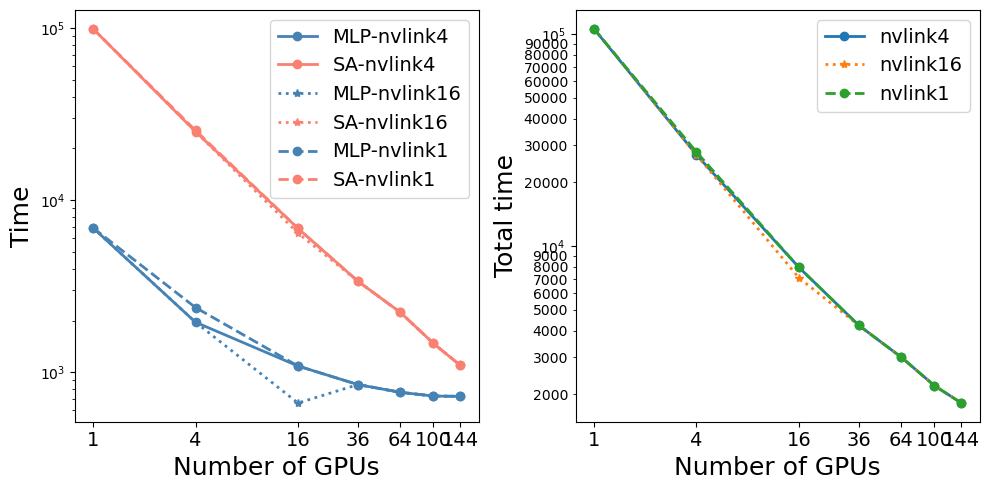

In [93]:
# Sweeps
### model parallelism
n_gpus = [1, 4, 16, 36, 64, 100, 144]
with open('config.json', 'r') as file:
    system = json.load(file)
fig, axs = plt.subplots(1,2,figsize=(10,5), tight_layout=True) 
c1 = 'steelblue'
c2 = 'salmon'
fsz = 18

nvs = 4
system['nvlink_size'] = nvs
lgnd = ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot = ["nvlink{}".format(nvs)]
plot(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o-")
nvs = 16
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="*:")
system['nvlink_size'] = 1
lgnd += ["MLP-nvlink1", "SA-nvlink1"]
lgnd_tot += ["nvlink1"]
plot(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o--")

In [94]:
def set_gpus(n, nvs):
    parallelism = {}
    topology = {}
    factors_of_n = [[i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0]
    best_factor = factors_of_n[-1]
    parallelism['m1'] = best_factor[0]
    parallelism['m2'] = best_factor[1]
    
    if n <= nvs:
        # set all gpus within nvlink
        topology['t1'] = 'nvlink'
        topology['t2'] = 'nvlink'
    else:
        topology['t2'] = 'ib'
        topology['t1'] = 'nvlink' if parallelism['m2'] <= nvs else 'ib'
        
    # print(parallelism, topology)
    return parallelism, topology

def plot_2d(n_gpus, system, axs, lgnd=['MLP', 'SA'], lgnd_tot=['nvlink1'], lfmt="-"):
    t_mlp = []
    t_sa = []
    t_itr = []

    for n in n_gpus:
        parallelism, topology = set_gpus(n, system['nvlink_size'])
        
        df_mlp = mlp_2d(b, l, e, f, depth, parallelism=parallelism, topology=topology)
        df_sa = sa_2d_seqp(b, l, e, h, depth, parallelism=parallelism, topology=topology)

        t_mlp_ = (df_mlp['t_fwd'].sum() + df_mlp['t_bwd'].sum()) * depth
        t_sa_ = (df_sa['t_fwd'].sum() + df_sa['t_bwd'].sum()) * depth
        t_itr.append(t_mlp_ + t_sa_)
        t_mlp.append(t_mlp_)
        t_sa.append(t_sa_)

    
    ax = axs[0]
    ax.plot(n_gpus, t_mlp, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_sa, lfmt, linewidth=2, c=c2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Time', fontsize=fsz)    
    ax.legend(lgnd, fontsize=fsz-4)
    
    ax = axs[1]
    ax.plot(n_gpus, t_itr, lfmt, linewidth=2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total time', fontsize=fsz)
    ax.legend(lgnd_tot, fontsize=fsz-4)
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%d"))

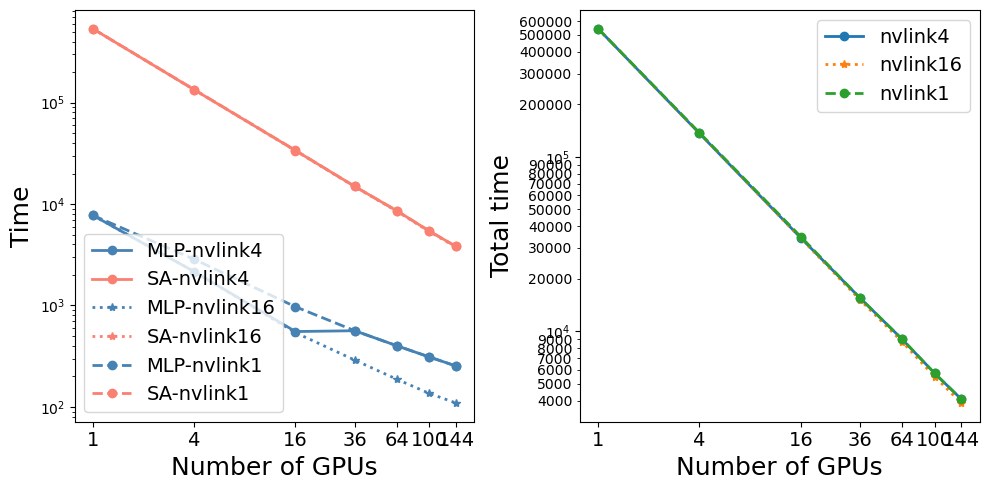

In [95]:
# Sweeps
### model parallelism
n_gpus = [1, 4, 16, 36, 64, 100, 144]
with open('config.json', 'r') as file:
    system = json.load(file)
fig, axs = plt.subplots(1,2,figsize=(10,5), tight_layout=True) 
c1 = 'steelblue'
c2 = 'salmon'
fsz = 18

lgnd = []
lgnd_tot = []
nvs = 4
system['nvlink_size'] = nvs
lgnd = ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot = ["nvlink{}".format(nvs)]
plot_2d(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o-")
nvs = 16
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot_2d(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="*:")
system['nvlink_size'] = 1
lgnd += ["MLP-nvlink1", "SA-nvlink1"]
lgnd_tot += ["nvlink1"]
plot_2d(n_gpus, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o--")